## Dependencies

In [507]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

In [508]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

start = '2018-01-01 00:00:00'
end = '2019-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.03)


## Solving forward

In [509]:
## Contstraints and constants

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

inflow_hydro1_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}
inflow_hydro2_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}

def inflow1_scenario(model, i, j):
    scenario_value = model.scenario.value
    if i == 'Hydro1':
        return model.inflow[i, j] == inflow_hydro1_scale[scenario_value] * inflow_hydro1[j]
    elif i == 'Hydro2':
        return model.inflow[i, j] == inflow_hydro2_scale[scenario_value] * inflow_hydro2[j]
# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['Buy',j] == model.L[j] - (model.r[j])

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) - (model.s[i,j]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) +(model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) -(model.s[i,j]*fm3)   

### Handling future cost

,Stage 50,Stage 49,Stage 48,Stage 47,Stage 46,Stage 45,Stage 44,Stage 43,Stage 42,Stage 41,...,Stage 10,Stage 9,Stage 8,Stage 7,Stage 6,Stage 5,Stage 4,Stage 3,Stage 2,Stage 1
"(0, 0)",131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,...,284419.686827,284419.686827,276776.942194,276776.942194,276776.942194,276776.942194,276776.942194,276776.942194,273806.696868,273806.696868
"(0, 4)",273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,...,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440
"(0, 8)",345530.777440,345530.777440,349258.436656,349258.436656,349258.436656,349258.436656,349258.436656,349258.436656,383048.379420,383048.379420,...,380622.606150,380622.606150,380622.606150,380622.606150,394645.056515,394645.056515,394645.056515,394645.056515,394645.056515,394645.056515
"(0, 12)",383615.019803,383615.019803,383615.019803,383615.019803,383615.019803,383615.019803,370975.598278,370975.598278,370975.598278,370975.598278,...,374654.693893,374654.693893,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691
"(0, 16)",366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,...,362258.270212,362258.270212,362258.270212,362258.270212,362258.270212,362258.270212,373151.160553,373151.160553,373151.160553,373151.160553
"(0, 20)",373151.160553,373151.160553,377136.416984,377136.416984,377136.416984,377136.416984,377136.416984,377136.416984,362548.890155,362548.890155,...,376256.500139,376256.500139,376256.500139,376256.500139,359952.099155,359952.099155,359952.099155,359952.099155,359952.099155,359952.099155
"(9, 0)",351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,...,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108
"(9, 4)",341455.423108,341455.423108,341455.423108,341455.423108,358278.334122,358278.334122,358278.334122,358278.334122,358278.334122,358278.334122,...,321898.783517,321898.783517,321898.783517,321898.783517,321898.783517,321898.783517,237038.538171,237038.538171,237038.538171,237038.538171
"(9, 8)",237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,...,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490
"(9, 12)",202136.873626,202136.873626,202136.873626,202136.873626,202136.873626,202136.873626,264242.874667,264242.874667,264242.874667,264242.874667,...,253469.386377,253469.386377,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280


273806.6968682382


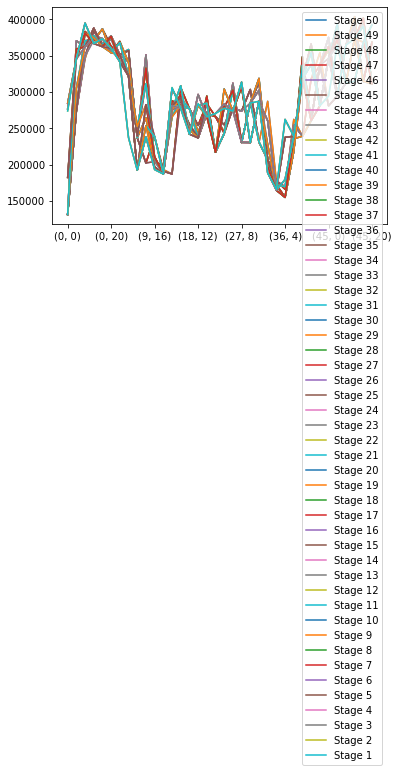

In [510]:
# Read water values and make them readable
fc = pd.read_csv('data/water_values.csv', index_col=0)
display(fc)
fc.plot()

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
fc.index = fc.index.map(label_parser)

#map so that stage in stages call on the string name of the column in the dataframe when solving later
column_mapping = {i: f'Stage {i}' for i in range(1, 51)}   #this is needed because the column names are not integers, but strings
        
# Access a specific value using a tuple as the row label
value = fc.loc[(0, 0), column_mapping[1]]
print(value)

In [511]:
def solve_first_stage(constants, topology, stage, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    print(max(model.periods))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart']) 
    print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)


    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    print("This is volume", max(model.v))
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)

    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first, sense=pyo.minimize)
    return model


#Solving functions:
def OBJ_first(model):
    return sum(model.probs * (model.r[j] * model.Ri  + model.Mi[j] * model.m['Buy', j]) for j in model.periods) 

def OBJ_forward(model):
    return sum(model.probs * (model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) #+ model.alpha


def create_alpha(model):
    return model.alpha >= model.phi - model.lambda1*(model.v['Hydro1',max(model.periods)] - model.v0['Hydro1']) + model.lambda2*(model.v['Hydro2',max(model.periods)] - model.v0['Hydro2'])

#in create alph,a lambda is multiplied with x_now - x_ref

def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [512]:
def solve_forward(constants, topology, stage, start_vol, expected, dual1, dual2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Define the inflow scenarios and associated probabilities

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24+1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    # Cut parameters
    model.phi     = pyo.Param(initialize = expected)
    model.lambda1 = pyo.Param(initialize = dual1[1])           #model.periods, initialize={j: dual1[j] for j in model.periods}) # 
    model.lambda2 = pyo.Param(initialize = dual2[1])           #model.periods, initialize={j: dual2[j] for j in model.periods}) # 
    print("This is dual1", model.lambda1.value)
    print("This is dual2", model.lambda2.value)
    print("This is phi", model.phi.value)


    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize={'Hydro1': start_vol[0], 'Hydro2': start_vol[1]}) 
    print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, rule=volume_change_rule)
    model.alpha_cons = pyo.Constraint(rule=create_alpha)
    print("This is alpha value", model.alpha.value)

    #phi = expected
    #lambda1 = dual1
    #lambda2 = dual2

    #model.alpha_cons = pyo.ConstraintList()                              #Not really necessary since it's only adding one constraint that resets for every stage buy hey if it works it works
    #model.alpha_cons = pyo.constraint(rule=create_alpha)                #constraint to limit the alpha variable from breaching the set alpha function
    #model.alpha_cons.add(model.alpha >= phi - sum(lambda1[1]*model.v[max(model.periods), s] + lambda2[1]*model.v[max(model.periods), s] for s in model.scenarios)) #- lambda2_values[i]*(sum(model.v['Hydro2', max(model.periods), s] for s in model.scenarios)/len(model.scenarios)) 
        
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)       #model.alpha is called here and should already be defined by the constraints or variable
        
    
    return model



In [513]:
s = 'High'


a = constants['inflow_probabilities'][s]

print(a)

0.3333333333333333


In [514]:
## Solving forward loop for each stage after first stage
    # Solve individually for each stage and obtain the model.v values at the end of each stage
stages=range(1, 5 + 1, 1)
scenarios= ['High'] #, 'Avg', 'Low'

Dual_values1={}
Dual_values2={}

constants['inflow_probabilities'] 

for s in scenarios:
    end_volume = {}
    print(' ')
    print('Solving for scenario', s)
    print(' ')
    #Saving volume values for each scenario in first stage
    for stage in stages:
        if stage == 1:
            print(' ')
            print('Week: ', stage)
            model = solve_first_stage(constants, topology, stage, s) 
            solve(model)
            expected = model.obj()
            #displayresults(model)
            stage_results = ()  # Dictionary to store results for each stage

            for i in model.plants:
                reservoir_v = model.v[i, max(model.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)

            Dual_values1[stage]= model.dual.get((model.volume_change_cons['Hydro1', max(model.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
            Dual_values2[stage]= model.dual.get((model.volume_change_cons['Hydro2', max(model.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
        else:
            print(' ')
            print('Week: ', stage)
            model_forward = solve_forward(constants, topology, stage, start_vol, expected, Dual_values1, Dual_values2, s) #start_vol is the X_hat
            print("Start volume of stage ", stage, " is: ", model_forward.v0)
            solve(model_forward)
            expected = model_forward.obj()
            
            stage_results = ()  # Dictionary to store results for each stage

            for i in model_forward.plants:
                reservoir_v = model_forward.v[i, max(model_forward.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            print("End volume of stage ", stage, " is: ", end_volume)
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)

            Dual_values1[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro1', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
            Dual_values2[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro2', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
           
            #alpha = create_alpha(model_forward,expected, Dual_values1, Dual_values2)


    print(Dual_values1)
    print(Dual_values2) 

    #Update start_vol_init based on the volume values at the end of the stage
    #start_vol_init = stage_volumes[stage]['High']
    #print(start_vol_init)


#    else:
#        forward_stage = solve_forward(constants, topology, stage, alpha)
#        solve(forward_stage)
#        results = {}
#        stage_volumes[stage] = {}
#        #Saving volume values for each scenario in the forward stages
#        for s in forward_stage.scenarios:
#            scenario_results = ()  # Dictionary to store results for each scenario
#            for i in forward_stage.plants:
#                # Extract the v values at the end of model.periods and store them
#                reservoir_v = forward_stage.v[i, max(forward_stage.periods), s].value
#                scenario_results += (reservoir_v,)
#            results[s] = scenario_results
#            
#            #INTERPOLATION TO FIND WATER VALUE BASED ON THE TOUPLE OF VOLUMES
#            target_tuple = results[s]                                                                      #Volume states at different scenarios
#            previous, next = create_tuples(target_tuple, stage, wv)                                        #Creating the previous and next tuple to prepare for interpolation
            
            #Findin alpha from interpolation ---> used in next stgae
#            alpha = trilinear_interpolation(previous, next, target_tuple)                                  #Interpolation function
#            print(alpha)

 
Solving for scenario High
 
 
Week:  1
168
This is start volume: 45.0 20.0
This is volume ('Hydro2', 168)
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1176 rows, 2856 columns and 3524 nonzeros
Model fingerprint: 0xf2b5f3de
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [1e-02, 5e+02]
Presolve removed 879 rows and 1933 columns
Presolve time: 0.01s
Presolved: 297 rows, 923 columns, 1216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9103480e+05   7.367106e-02   0.000000e+00      0s
     295    5.9326084e+05   0.000000e+00   0.000000e+00      0s

Solved in 295 iterations and 0.01 seconds (0.01 work units)
Optimal objective  